<a href="https://colab.research.google.com/github/Daniblue25/My-medical-work/blob/main/cancer_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse et segmentation d'images avec torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1. Importation des librairies necessaires

In [ ]:
import cv2
import glob
import tqdm
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from mpl_toolkits.axes_grid1 import ImageGrid

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 2. Definition d'un set_seed

## 3. Importation de la data

In [ ]:
mask_files = glob.glob('lgg-mri-segmentation/kaggle_3m/*/*_mask*')

In [ ]:
diagnos = [np.any(cv2.imread(file)) for file in tqdm(mask_files)]
image_files = [file.replace('_mask', '') for file in tqdm(mask_files)]

100%|██████████| 3929/3929 [00:00<00:00, 561766.50it/s]


In [ ]:
# Etablissons une table contenant les 3 variables

df = pd.DataFrame({"image_path": image_files, "mask_path": mask_files, "diagnos": diagnos})

In [ ]:
df.sample(3).T

,3784,420,2829
image_path,lgg-mri-segmentation/kaggle_3m\TCGA_HT_A61A_20...,lgg-mri-segmentation/kaggle_3m\TCGA_DU_5851_19...,lgg-mri-segmentation/kaggle_3m\TCGA_FG_A60K_20...
mask_path,lgg-mri-segmentation/kaggle_3m\TCGA_HT_A61A_20...,lgg-mri-segmentation/kaggle_3m\TCGA_DU_5851_19...,lgg-mri-segmentation/kaggle_3m\TCGA_FG_A60K_20...
diagnos,True,False,False


In [ ]:
df.shape

(3929, 3)

## 4. Representation graphique

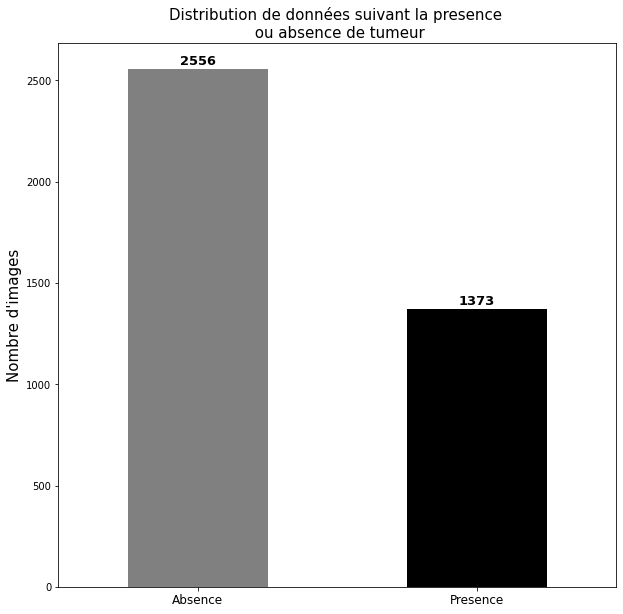

In [ ]:
ax = df['diagnos'].value_counts().plot(kind='bar', stacked=True, figsize=(10, 10), color=['gray', 'black'])
ax.set_ylabel("Nombre d'images", fontsize=15)
ax.set_title('Distribution de données suivant la presence \n ou absence de tumeur', fontsize=15)
ax.set_xticklabels(['Absence', 'Presence'], fontsize=12, rotation=0)

for i, rows in enumerate(df['diagnos'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows + 20), ha='center', fontweight='bold', fontsize=13)

## 5. Partitionnement

In [ ]:
train_df, val_df = train_test_split(df, stratify=df['diagnos'], test_size=0.12, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnos'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
train_df['diagnos'].value_counts()

False    1911
True     1027
Name: diagnos, dtype: int64

In [ ]:
print(f"Train : {train_df.shape} => {round(len(train_df) / len(df), 2)}")
print(f"Validation : {val_df.shape} => {round(len(val_df) / len(df), 2)}")
print(f"Test : {test_df.shape} => {round(len(test_df) / len(df), 2)}")

Train : (2938, 3) => 0.75
Validation : (472, 3) => 0.12
Test : (519, 3) => 0.13


## 6. Visualisation de quelques images

In [ ]:
images, masks = [], []
df_positive = train_df[train_df['diagnos'] == 1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)

images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

In [ ]:
train_df[train_df['diagnos'] == 1].sample(1)[["image_path", "mask_path"]].values[0]

array(['lgg-mri-segmentation/kaggle_3m\\TCGA_FG_A4MT_20020212\\TCGA_FG_A4MT_20020212_14.tif',
       'lgg-mri-segmentation/kaggle_3m\\TCGA_FG_A4MT_20020212\\TCGA_FG_A4MT_20020212_14_mask.tif'],
      dtype=object)

In [ ]:
image_path, mask_path = train_df[train_df['diagnos'] == 1].sample(1)[["image_path", "mask_path"]].values[0]

**Affichage**

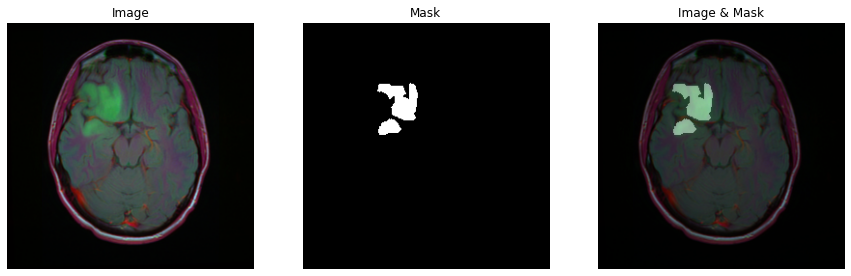

In [ ]:
index_sample = 2
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

image_sample = cv2.imread(image_path)
mask_sample = cv2.imread(mask_path)

axs[0].imshow(image_sample)
axs[0].set_title("Image")
axs[0].set_axis_off()

axs[1].imshow(mask_sample)
axs[1].set_title("Mask")
axs[1].set_axis_off()

# Superposition de l'image et de son mask
axs[2].imshow(image_sample)
axs[2].imshow(mask_sample, alpha=.4)
axs[2].set_title("Image & Mask")
axs[2].set_axis_off()

plt.show()

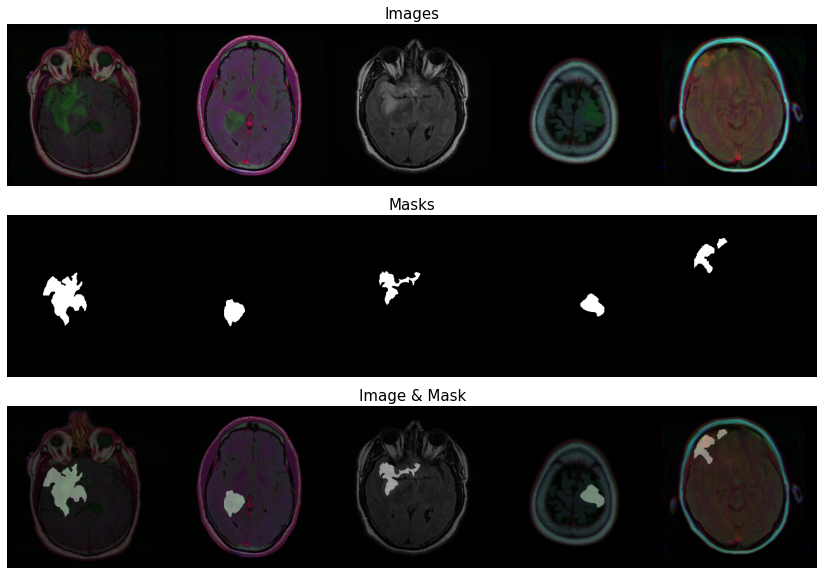

In [ ]:
fig = plt.figure(figsize=(15,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.4)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)

grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')

grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Image & Mask', fontsize=15)
grid[2].axis('off')
plt.show()

## 7. Augmentation de donnée avec générateur d'images

In [ ]:
def create_gens(df, aug_dict):
    img_size = (256, 256)
    batch_size = 40


    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    # Create general generator
    image_gen = img_gen.flow_from_dataframe(df, x_col='image_path', class_mode=None, color_mode='rgb', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='mask_path', class_mode=None, color_mode='grayscale', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix= 'mask', seed=1)

    gen = zip(image_gen, mask_gen)

    for (img, mask) in gen:
        img = img / 255
        mask = mask / 255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0

        yield (img, mask)

In [ ]:
tr_aug_dict = dict(
                            rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')


train_gen = create_gens(train_df, aug_dict=tr_aug_dict)
valid_gen = create_gens(val_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})

In [ ]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]
        # read image and convert it to RGB scale
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read mask
        mask = cv2.imread(mask_path)
        # sho image and mask
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

## 7. Conception du modèle Unet

In [ ]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    ##########################################################

    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

## 8. Fonction de coef et de perte

In [ ]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

## 9. Appel du modele

In [ ]:
model = unet()
model.compile(Adamax(learning_rate= 0.001), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

## 10. Fonction de representation graphique de l'entrainement

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_iou = np.argmax(iou_coef)
    iou_highest = val_iou[index_iou]
    index_dice = np.argmax(dice_coef)
    dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

## 11. Entrainement du modèle

In [ ]:
epochs = 120
batch_size = 40
callbacks = [ModelCheckpoint('My_unet.hdf5', verbose=0, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_df) / batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data = valid_gen,
                    validation_steps=len(val_df) / batch_size)

In [ ]:
plot_training(history)

## 12. Evaluation du modèle

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])